# ML Adaptive Beamformer for ULA
---


## Quiescent Beamforming

First as a background, the quiescent (e.g. static) case of a linear array will be considered. The non-dynamic beamforming weights will be derived for a given steering direction. We will also show the basis of Digital Beamforming (DBF) with these static weights.

Lets also import the necessary Python packages and libraries now too:

In [1]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants

import tensorflow as tf

### Uniform Linear Array Parameters & System Constants

Set the parameters and system constants for the Uniform Linear Array (ULA):

> NOTE: to prevent grating lobes, the antenna element spacing should be $\frac{d}{\lambda}=0.5$

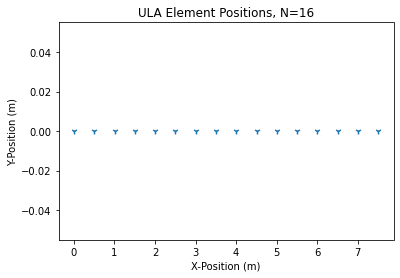

In [2]:
N       = 16    # number of elements in ULA
fc      = 300e6 # RF carrier frequency (assuming narrowband here)
fs      = 1e9   # IF/direct sampling frequency
theta   = 0     # desired signal Angle of Arrival (AoA) in degrees
SNR     = 1     # element SNR (linear units)
noiseP  = 1     # noise power (linear units)
spacing = 0.5   # d/wavelength element spacing (0.5 = half-wavelength spacing)

wavelength = fc/scipy.constants.c
# generate array of antenna element positions
antPos = np.linspace(0,N-1,N)*wavelength*spacing
plt.scatter(antPos, np.zeros(N), marker='1')
plt.title("ULA Element Positions, N=%i" % N)
plt.ylabel("Y-Position (m)")
plt.xlabel("X-Position (m)")
plt.show()

### Spatial Response

Create spatial response vector at each ULA element that follows
$$ e^{\frac{j2\pi}{\lambda} \sin{\theta} } $$

In [3]:
cmplx_pos = (1j*2*np.pi/wavelength)*antPos.T
d = np.exp(cmplx_pos*np.sin(np.deg2rad(theta)))

Compute hypothesis of steering vectors in sine space for quiescent beamforming weights. Plot the weight response over sine space by testing weight magnitude at each look direction in vector `u`, from $-90^{\circ}$ to $90^{\circ}$

In [4]:
numHyp = 400 # number of direction hypothesis to compute
u = np.linspace(-1,1,numHyp)
# create matched filter (beam weights) for quiescent case (no interference)
wq = np.exp(np.outer(np.array(cmplx_pos), u))
# unit normalize filter weights
mag = wq * wq.conj()
wq = wq / mag.sum(axis=0) # sum over columns (each channel, per hypothesis)

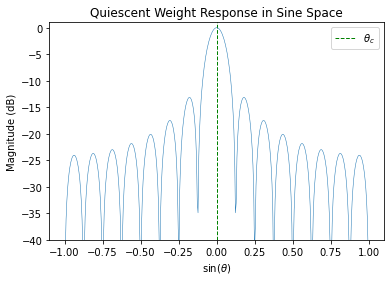

In [5]:
yq = np.inner(wq.conj().T, d)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Quiescent Weight Response in Sine Space')
ax.set_ylim([-40, 1]) # set sensible magnitude limits since edges near 0 gain
ax.vlines(np.sin(np.deg2rad(theta)), -40, 1, colors='green', linestyles='dashed', label=r'$\theta_{c}$', linewidth=1)
ax.legend()
plt.show()

#### Windowing Quiescent Weights

[Windowing](https://en.wikipedia.org/wiki/Window_function) can be applied to weights as well to adjust sidelobes, such as applying a Hamming window which is weighted by:
$$ w(n) = 0.54 - 0.46\cos(\frac{2\pi n}{M - 1}) \quad 0 \leq n \leq M - 1 $$

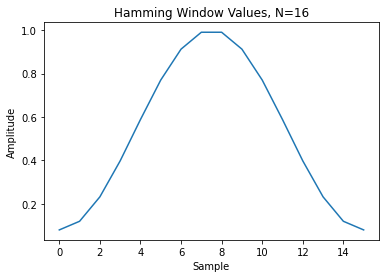

In [6]:
window = np.hamming(N)
plt.plot(window)
plt.title("Hamming Window Values, N=%i" % N)
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

As expected, the great reduction in sidelobes causes an increase in mainlobe width compared to non-windowed weights. Windowing is always a balance between sidelobe performance and mainlobe width.

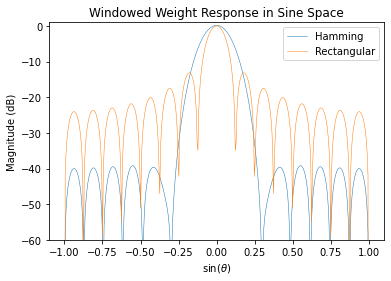

In [7]:
w_ham = window * d
# normalize Hamming windowed weights to 0dB by giving 6dB gain (mainlobe is attenuated by 6dB)
w_ham *= 10.0**(6.0/20.0)
y_ham = np.inner(wq.conj().T, w_ham)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(y_ham)), u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Windowed Weight Response in Sine Space')
ax.set_ylim([-60, 1]) # set sensible magnitude limits since edges near 0 gain
ax.legend(['Hamming', 'Rectangular'])
plt.show()

### Response to Off-Angle Interference

Here we create an interference signal at a different angle of arrical than our intended signal.

In [8]:
thetaInf = 30 # intereference signal Angle of Arrival (AoA) in degrees
fInf = 0.9*fc # interference signal carrier frequency (assuming narrowband)
wavelengthInf = fInf/scipy.constants.c

M = N*128 # M received samples/ch, where M ≥ N channels to form MxN sample matrix
# time vector based on sampling frequency
t = np.linspace(1,M,M)/fs
t.shape = (1,M) # force transpose

# calculate phase shift of interefence wave over ULA, similar to desired signal above,
# but with different shift based on different AoA
cmplx_posInf = (1j*2*np.pi/wavelengthInf)*antPos.T
dInf = np.exp(cmplx_posInf * np.sin(np.deg2rad(thetaInf)))

# phase shift received ideal waveform w/o noise or interference
rx = np.sqrt(SNR*noiseP) * np.exp(1j*2*np.pi*fc*t)
rx_shft = np.outer(rx, np.matrix(d)).T

# create random RX noise (thermal, environmental, etc.) across array
infNoise = np.sqrt(noiseP/2) * (np.random.randn(N,M) + 1j*np.random.randn(N,M))

# interference waveform with interference phase shift based on its frequency (again assumed narrowband)
infRx = np.sqrt(SNR*noiseP) * np.exp(1j*2*np.pi*fInf*t)
infRx_shft = np.outer(infRx, np.matrix(dInf)).T

# add interference & noise to create combined, synthetic RX waveform
rx_all = rx_shft + infNoise + infRx_shft

Next, we show a comparison between no digital beamforming and a simple DBF with quiescent weights in the presence of an interferer and noise.

Notice that since the interference is off angle, and the basic sum averaging case is the same as having quiescent weights for a look directly at boresight (0 degrees), the 30 degree interference is seen but at a lower power since it falls within a sidelobe (see weight plots above).

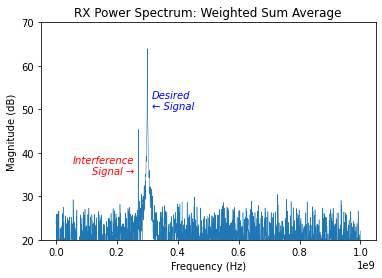

In [9]:
# perform basic sum averaging across all channels for "no DBF" case
nonDBF = np.sum(rx_all, axis=0)/N

# plot FFT power spectrum of RX signals
freqBin = np.linspace(1,M,M)*(fs/M)
nonDBF_PSD = 20*np.log10(np.abs(np.fft.fft(nonDBF)))
fig, ax = plt.subplots()
ax.plot(freqBin, nonDBF_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: Weighted Sum Average')
ax.text(fInf*.95, 35, 'Interference\nSignal →', horizontalalignment='right', color='red', fontstyle='italic')
ax.text(fc*1.05, 50, 'Desired\n← Signal', color='blue', fontstyle='italic')
ax.set_ylim([20, 70])
plt.show()

## MVDR Beamforming

Minimum Variance Distortionless Response (MVDR) minimizes the total array power while maintaining unity gain for signals in the desired direction [1]. Essentially this process minimizes noise and off-angle interference signals' powers by placing spatial nulls at certain array angles (also known as "null steering"). The MVDR beamforming weights, $w$, can be calculated by:
$$ w = \frac{ \boldsymbol{S}^{-1} \boldsymbol{v_{0}} } { \boldsymbol{v_{0}}^{H} \boldsymbol{S}^{-1} \boldsymbol{v_{0}} } $$
where $\boldsymbol{S}$ is the spatial sample covariance matrix, and $\boldsymbol{v_{0}}$ is the complex steering vector representing the phase shifts across the array to form the desired steering direction.

[1] Van Trees, H.L. _Optimum Array Processing_. New York, NY: Wiley-Interscience, 2002.

In [10]:
# Given N channels, with M samples per channel & M ≥ N
#   input args: X = 2D input sample array(M samples x N elements), sv = steering vector(N x 1)
#   returns tuple Y, w: Y = output beam row vector(1 x M), w = MVDR weight col vector(N x 1)
def MVDR_beamform(X, sv):
    # form covariance matrix of input samples
    Ecx = X.T @ X.conj()
    # compute weight vector using steering vector and inverting matrix
    # solves for x in Ax=b, where A is the covariance sample matrix, and b is the steering vector
    wp, resid, rank, s = np.linalg.lstsq(Ecx, sv, rcond=None)
    # normalize weight response
    w = wp/(np.matrix(sv).H * wp)
    # form output beam with MVDR computed weights
    # TODO: why does below work but not -> Y = X * np.conjugate(w)
    Y = np.zeros(M) + 1j*np.zeros(M)
    for i in range(N):
        for j in range(M):
            Y[j] += X[j,i] * np.conjugate(w[i])
    return Y, w

### Adaptive Beamforming Application

We can now apply the MVDR calculation to our combined RX data set (containing noise and the desired + intereference signal sources):

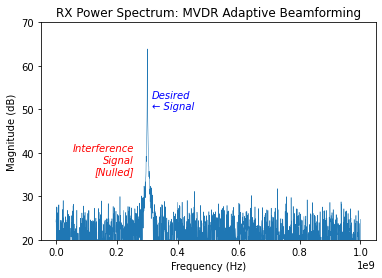

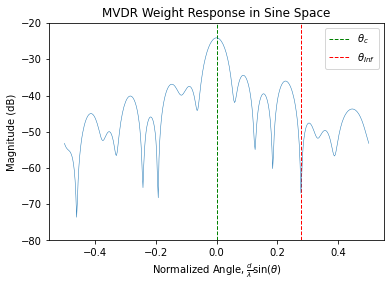

In [13]:
steer_vec = np.matrix(d).T
Y_MVDR, w_MVDR = MVDR_beamform(np.matrix(rx_all).T, steer_vec)

MVDR_PSD = 20*np.log10(np.abs(np.fft.fft(Y_MVDR)))
fig, ax = plt.subplots()
ax.plot(freqBin, MVDR_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: MVDR Adaptive Beamforming')
ax.text(fInf*.95, 35, 'Interference\nSignal\n[Nulled]', horizontalalignment='right', color='red', fontstyle='italic')
ax.text(fc*1.05, 50, 'Desired\n← Signal', color='blue', fontstyle='italic')
ax.set_ylim([20, 70])
plt.show()

sin_mvdr = w_MVDR.H * wq
sin_mvdr = sin_mvdr.T
fig, ax = plt.subplots()
ax.plot(u*spacing, 20*np.log10(np.abs(sin_mvdr)), linewidth=0.5)
ax.set(xlabel=r'Normalized Angle, $\frac{d}{\lambda} \sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='MVDR Weight Response in Sine Space')
ax.set_ylim([-80, -20]) # set sensible magnitude limits since edges near 0 gain
# NOTE: since interference tone is at different frequency than desired tone,
#       the normalized sine space plot scales the incidence angles by its wavelength
ax.vlines(np.sin(np.deg2rad(theta))*spacing/wavelength, -80, -20, colors='green', linestyles='dashed', label=r'$\theta_{c}$', linewidth=1)
ax.vlines(np.sin(np.deg2rad(thetaInf))*spacing/wavelengthInf, -80, -20, colors='red', linestyles='dashed', label=r'$\theta_{Inf}$', linewidth=1)
ax.legend()
plt.show()

Here we can see that the off-angle interference wave is nulled out of the frequency response, yet the desired signal is at the same gain as the previous weighted-sum average spectrum.

## ML Beamforming


### Input Layer

---

## Notes/`TODO`:
- Decided on CNN model for adaptation to ABF use case:
  + I still want to build the covariance sample/estimation matrix on front end before the CNN;(its easy (HDL and implementation is fairly easy and not very resource heavey), and input layer is then pretty simple. For instance, instead of having to "window" a certain amount of data (say 1000 samples) for each channel as the input layer (which could be very resource heavy) an 8 channel system can have a 2D 8x8 input layer (8 channel rows x 8 covariance columns x 2 samples per I/Q) which should lead to much lighter overall resource usage (and easier training)
    * The above input layer is not fully complete though, I also need to have some way to input the desired steering direction, perhaps as just a separate "channel"? (e.g. a 9x8 input layer for the 8 true channel case, where the extra row is the set of steering weights `d`, similar to how this vector is given in traditional QRD processes?). This should be OK since a CNN has no concept of what's what, the "magic" will be in training it anyways...
    * I do also want to model some scenarios where I _don't_ have the covariance matrix on the front end, just to see how much larger the overall CNN becomes with the much wider input layer. Through training, the CNN might "come up" with a more efficient/better model anyways...
    * Two other interesting input preprocessing should also be considered:
      - Using [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (or overlapped/RTSA to get both time & frequency resolution) BUT instead of taking it across the temporal domain (e.g. across the time domain of each channel's samples like traditional FFT processing), we take it across the spatial dimension (e.g. across all channels, btw could process an 8-channel system with 8-pt FFT per sample, or larger FFT like 64-pt+ by stacking inputs?). We can make a good comparison to STFT used in audio/RF classification tasks (like TF's example and RadioML)
      - Investigate performance with input from [CWT, WVD or other time-frequency transform](https://www.mathworks.com/help/signal/ug/time-frequency-gallery.html#responsive_offcanvas)?
      - Investigate any other [Lossy Compression](https://en.wikipedia.org/wiki/Lossy_compression) preprocessing methods, like [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform) or [DWT](https://en.wikipedia.org/wiki/Discrete_wavelet_transform), which can create compressed 2D input layers?
  + The output layer should be 2D for complex weights (N channels x 2 per I/Q weight), since the goal is to have a CNN which can directly create weights for beamforming "weight and sum"/MAC application in PL logic.
  + The value function for training is based on computing the Signal to Interference + Noise (SINR) calculation for a given test's output weights and training sample set; the greater the SINR, the greater the "accuracy". This may lead to a more compute intensive training process (as opposed to simple/traditional classification examples which can build confusion matrices/binary success models), but SINR calculation is not too terrible
    * Reinforcement learning vs supervised (since not labeled data set)?
  + The generated test data sets for each training epoch can be built on-the-fly since, with given mathematical RF signal models, we can create relatively realistic test data. Different parameters should vary to best train the CNN (as well as buck "overfitting" to a specific dataset/test) like:
    * Desired & interference signal modulation and bandwidths (e.x. simple AM/tone, QPSK, QAM, OFDM, LFM/chirp, etc.)
    * Noise, including noise type (e.g. more than just gaussian white noise), also varying if noise is phase shifted along with interference signal
    * Number of interference sources (up to num_channels - 1 theoretical nulling limits)
    * Desired & interference signal directions
    * Desired & interference signal SNRs
      + In Tim O'Shea's RadioML research, he built an interesting graph which was able to show model accuracy vs input SNR, where expectedly, very low SNR (or signals below noise) led to less probability of modulation classification (different application than us btw, though the RadioML dataset could be another interesting test source)
    * Since we have lots of desired _features_ for our training data set, we should also explore using _dimensionality reduction_ algorithms on this very large dataset for feature extraction
      + Also since we have a lot of features, perhaps we start testing with only one or two features to also not overfit
  + For documentation comparison of ML results (besides implementation performance in real PL fabric- hopefully its smaller/faster!), compare "performance" (SINR) of ML model to full SMI, MVDR (the perfect case doing sample inversion on entire dataset).
  + At the end of creating floating-point model in TensorFlow, the extra quantization tools (which are used for embedded targets like TF Lite) should output a fixed point model for comparison as well (since this would be easiest/most resource optimized for FPGA logic implementation)
    * Full FP32 model is still useful though as we could use HLS tools like Xilinx Vitis AI and hls4ml to create PL blocks for resource/performance comparison.